# Generating Shakespeare character by character

This is a small example of a GPT that is trained on Shakespeare text. This notebook has major inspiration from https://github.com/karpathy/nanoGPT. It's great to get familiar and play around with GPT alwhile not necessarly having a cluster of 1000s of GPUs.

In [22]:
import os
import pickle

import matplotlib.pyplot as plt
import torch
from nanoLLMs.misc import get_batch
from nanoLLMs.misc import generate_text
from nanoLLMs.model import GPT2, Mamba, xLSTM
from nanoLLMs.trainer import Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

We launch the `data/shakespeare_char/prepare.py` file in order to have our data setup.

In [23]:
! python ../data/shakespeare_char/prepare.py 

length of dataset in characters: 1,115,394
all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65
train has 1,003,854 tokens
val has 111,540 tokens


In this dataset we have 65 unique characters (i.e. tokens) that forms our vocabulary size, 1M tokens for training and 100k for validation.

In [24]:
data_dir = "../data/shakespeare_char/"
meta_path = os.path.join(data_dir, "meta.pkl")
vocab_size = None

if os.path.exists(meta_path):
    with open(meta_path, "rb") as f:
        meta = pickle.load(f)
    vocab_size = meta["vocab_size"]
    itos = meta["itos"]
    stoi = meta["stoi"]
    print(f"found vocab_size = {vocab_size} (inside {meta_path})")

found vocab_size = 65 (inside ../data/shakespeare_char/meta.pkl)


We then get some meta data and other convienences. For example, the GPT trained hereafter will have the task of predicting the next Shakesperian character given its context. Autoregressively, you can generate many characters that will eventually form words and sentences.

The function `encode` and `decode` will help to bridge the gap between produced GPT output into readable characters and readable characters into data.

We also provide an example of how a `str` is encoded for the model and how the model's output `array` of `int` are decoded to produce Shaspearian literature.

In [25]:
encode = lambda s: torch.tensor([stoi[c] for c in s])
decode = lambda l: "".join([itos[i] for i in l])

shakpeare_lines = "the king will"
x = encode(shakpeare_lines)
y = decode(x.tolist())
assert shakpeare_lines == y

print("The text '{}' is encoded and fed to the GPT as {}".format(shakpeare_lines, x))

The text 'the king will' is encoded and fed to the GPT as tensor([58, 46, 43,  1, 49, 47, 52, 45,  1, 61, 47, 50, 50])


We then choose to use the same hyperparameters from https://github.com/karpathy/nanoGPT for a small example of CPU. 

In [26]:
block_size = 64
n_layer, n_head, n_embd, dropout = 4, 4, 128, 0.0

model = GPT2(vocab_size, block_size, n_embd, n_head, n_layer)
model = model.to(device)
print("GPT number of parameters:", sum(p.numel() for p in model.parameters()))

GPT number of parameters: 813889


We instantiate also our `Trainer` class from `nanoLLMs/trainer.py` to start training our LLM. 

In [27]:
lr, batch_size, max_iters, checkpoint_path = 1e-3, 32, 1000, "../metadata/shakespeare_char/"
save_every, patience,  = 200, max_iters
generation_length, temperature = 256, 0.7

In [28]:
gpt_trainer = Trainer(model, lr=lr, checkpoint_path=checkpoint_path)

Created checkpoint directory at ../metadata/shakespeare_char/


We call the `train` method from our `trainer` that takes as input : 
- `get_batch`: a function that fetches batches of data
- `max_iters`: number of max iterations
- `batch_size`: batch size 
- `patience`: an argument that essentially stops the training if the validation loss hasn't improve in `#patience` optimization steps. 
- `save_every`: that saves the model weights and other things at `save_every` multiples of iteration step. 

In [29]:
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)
gpt_trainer.train(
    partial_get_batch, max_iters=max_iters, batch_size=batch_size, patience=patience, save_every=save_every
)

Iter :999/1000 Train Loss 1.690e+00 / Eval Loss 1.842e+00: 100%|██████████| 1000/1000 [00:20<00:00, 47.73it/s]


Let's see the loss curve from this training and also generate some text !

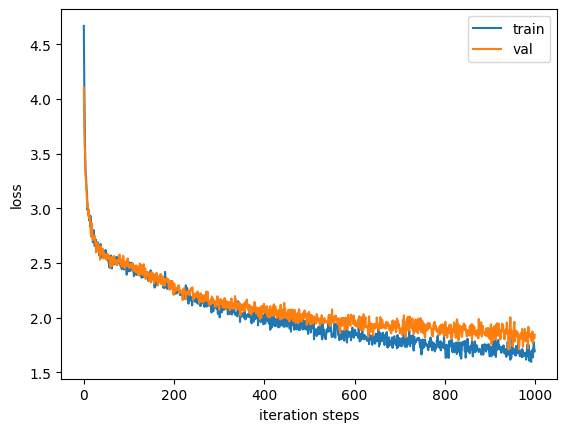

In [30]:
plt.plot(gpt_trainer.losses, label="train")
plt.plot(gpt_trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()
plt.savefig(gpt_trainer.checkpoint_path + "gpt_loss.png")

We also added a `temperature` and `top_k` hyperparameters to give a bit more flexibility to the text generation. 

In [31]:
input = "The "
tokens = encode(shakpeare_lines).view(1,-1)
tokens = tokens.to(device)
sample_text = generate_text(model, tokens, generation_length, temperature=temperature)
print("Generated Text:")
print(decode(sample_text.tolist()[0]))

Generated Text:
the king will by our home hear of the

SICINIUS:
My shall hear that manister: that the are of comple
To Beachious ware my heap's are as them the come
bouter'd with hath peace awore your mease.
If, that ear this not well arms, that his hape
Threre would the earfores of 


# Text generation with Mamba

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
d_model, expand, kernel_size, conv_bias, dt_rank, d_state, bias, dt_max, dt_min, dt_init_floor, dt_scale, n_layers, dt_init, use_cuda = 128, 2, 4, False, "auto", 64,  True, 0.1, 0.001, 1e-4, 1.0, 6, "random", True
model = Mamba(d_model, expand, kernel_size, conv_bias, dt_rank, d_state, bias, dt_max, dt_min, dt_init_floor, dt_scale, dt_init, use_cuda, n_layers, vocab_size=vocab_size, block_size=256)
model = model.to(device)
print("Mamba number of parameters:", sum(p.numel() for p in model.parameters()))

Failed to import mamba_ssm. Falling back to mamba.py.
Failed to import mamba_ssm. Falling back to mamba.py.
Failed to import mamba_ssm. Falling back to mamba.py.
Failed to import mamba_ssm. Falling back to mamba.py.
Failed to import mamba_ssm. Falling back to mamba.py.
Failed to import mamba_ssm. Falling back to mamba.py.
Mamba number of parameters: 936192


In [33]:
mamba_trainer = Trainer(model, lr=lr, checkpoint_path=checkpoint_path)
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)

Created checkpoint directory at ../metadata/shakespeare_char/


In [34]:
mamba_trainer.train(
    partial_get_batch, max_iters=max_iters, batch_size=batch_size, patience=patience, save_every=save_every
)

Iter :999/1000 Train Loss 1.419e+00 / Eval Loss 1.552e+00: 100%|██████████| 1000/1000 [16:03<00:00,  1.04it/s]


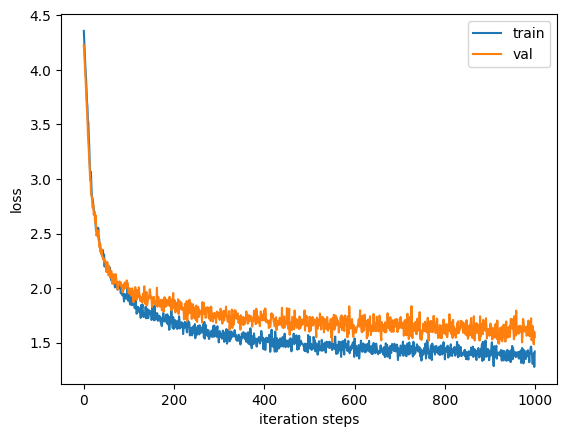

In [35]:
plt.plot(mamba_trainer.losses, label="train")
plt.plot(mamba_trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()
plt.savefig(mamba_trainer.checkpoint_path +"mamba_loss.png")

In [36]:
input = "The "
tokens = encode(shakpeare_lines).view(1,-1)
tokens = tokens.to(device)
sample_text = generate_text(model, tokens, generation_length, temperature=temperature)
print("Generated Text:")
print(decode(sample_text.tolist()[0]))

Generated Text:
the king will command he shame
Lest did of that he weak a brother, but mine own forth
Calls of the triumphants
To weep a call to our souls.

LADY GREY:
The too sweet in the noble ore in the sworn of our
comfortily Camillo this common
where own beauty,
I'll for this abs


# xLSTM 

In [37]:
embed_dim = 128
hidden_size = 128
num_layers = 2
num_blocks = 4
dropout = 0.1
max_seq_len = 256

model = xLSTM(vocab_size, embed_dim, max_seq_len, hidden_size, num_layers, num_blocks, dropout)
model.to(device)
print("xLSTM number of parameters:", sum(p.numel() for p in model.parameters()))

xLSTM number of parameters: 876353


In [38]:
xlstm_trainer = Trainer(model, lr=lr, checkpoint_path=checkpoint_path)
partial_get_batch = lambda split, batch_size: get_batch(
    data_dir, split, batch_size, device, block_size
)

Created checkpoint directory at ../metadata/shakespeare_char/


In [39]:
xlstm_trainer.train(
    partial_get_batch, max_iters=max_iters , batch_size=batch_size, patience=patience, save_every=save_every
)

Iter :999/1000 Train Loss 1.726e+00 / Eval Loss 1.808e+00: 100%|██████████| 1000/1000 [13:22<00:00,  1.25it/s]


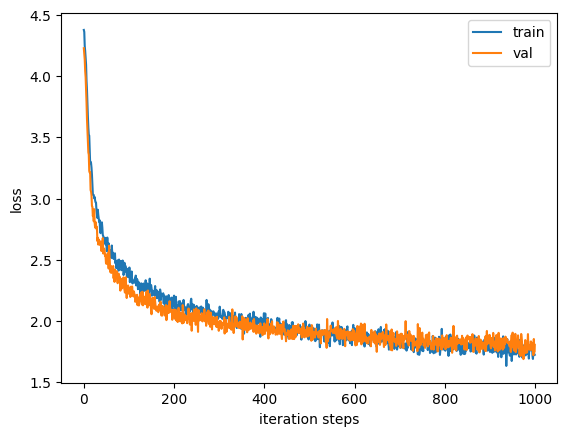

In [40]:
plt.plot(xlstm_trainer.losses, label="train")
plt.plot(xlstm_trainer.val_losses, label="val")
plt.xlabel("iteration steps")
plt.ylabel("loss")
plt.legend()
plt.savefig(xlstm_trainer.checkpoint_path + "xlstm_loss.png")

In [41]:
input = "The "
tokens = encode(shakpeare_lines).view(1,-1)
tokens = tokens.to(device)
sample_text = generate_text(model, tokens, generation_length, temperature=temperature)
print("Generated Text:")
print(decode(sample_text.tolist()[0]))

Generated Text:
the king will the was to seauch the heard I be be take thee from you, sweet a the gave with
I have noplenity, to die and will that ward none three's less at honour me?

POLIXENES:
Thou call tell:
Why, for than and will that say that your slong me,
As for your say scrai
